# Subgraph has two mechanism to implement in langraph:
## 1: parrent graph and subgraph is separate and separate start just only invoke from that parrent node the subgraph, this are not directly connected 
## 2: parrent and subgrraph are are connected directly.



In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
class SubState(TypedDict):

    input_text: str
    translated_text: str

In [5]:
subgraph_llm = ChatGroq(model="llama-3.3-70b-versatile")

In [7]:
def translate_text(state: SubState):

    prompt = f"""
Translate the following text to Hindi.
Keep it natural and clear. Do not add extra content.

Text:
{state["input_text"]}
""".strip()
    
    translated_text = subgraph_llm.invoke(prompt).content

    return {'translated_text': translated_text}

In [8]:
subgraph_builder = StateGraph(SubState)

subgraph_builder.add_node('translate_text', translate_text)

subgraph_builder.add_edge(START, 'translate_text')
subgraph_builder.add_edge('translate_text', END)

subgraph = subgraph_builder.compile()

In [9]:

class ParentState(TypedDict):

    question: str
    answer_eng: str
    answer_hin: str


In [10]:
parent_llm = ChatGroq(model="llama-3.3-70b-versatile")

In [11]:
def generate_answer(state: ParentState):

    answer = parent_llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion: {state['question']}").content
    return {'answer_eng': answer}

In [12]:
def translate_answer(state: ParentState):

    # call the subgraph
    result = subgraph.invoke({'input_text': state['answer_eng']})

    return {'answer_hin': result['translated_text']}

In [13]:
parent_builder = StateGraph(ParentState)

parent_builder.add_node("answer", generate_answer)
parent_builder.add_node("translate", translate_answer)

parent_builder.add_edge(START, 'answer')
parent_builder.add_edge('answer', 'translate')
parent_builder.add_edge('translate', END)

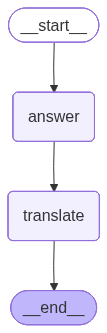

In [14]:
graph = parent_builder.compile()

graph

In [15]:
graph.invoke({'question': 'What is quantum physics'})

{'question': 'What is quantum physics',
 'answer_eng': '**Quantum Physics: A Brief Overview**\n\nQuantum physics, also known as quantum mechanics, is a branch of physics that studies the behavior of matter and energy at an atomic and subatomic level. At these scales, the classical laws of physics do not apply, and strange, seemingly random phenomena govern the behavior of particles.\n\n**Key Principles:**\n\n1. **Wave-Particle Duality**: Quantum objects, such as electrons, can exhibit both wave-like and particle-like behavior depending on how they are observed.\n2. **Uncertainty Principle**: It is impossible to know certain properties of a quantum object, such as its position and momentum, simultaneously with infinite precision.\n3. **Superposition**: Quantum objects can exist in multiple states simultaneously, which is known as a superposition of states.\n4. **Entanglement**: Quantum objects can become "entangled" in a way that the state of one object is dependent on the state of the 